In [ ]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# RTX On
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
def load_data(file):
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  # python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    data = np.array(data, dtype=np.float32) / 255
    labels = np.array(labels, dtype=np.int32)
    return data, labels

In [ ]:
def make_model(num_ch_c1, num_ch_c2, use_dropout):

    model = tf.keras.Sequential()

    # Input Layer
    model.add(layers.Input(shape=(3072,)))
    model.add(layers.Reshape(target_shape=(32, 32, 3), input_shape=(3072,)))
    
    # C₁ Convolutional Layer
    model.add(layers.Conv2D(num_ch_c1, 9, padding='valid', activation='relu', input_shape=(None, None, 3)))

    # S₁ Max Pooling Layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2), padding='valid'))
    
    # C₂ Convolutional Layer
    model.add(layers.Conv2D(num_ch_c2, 9, padding='valid', activation='relu', input_shape=(None, None, 3)))

    # S₂ Max Pooling Layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2), padding='valid'))

    # Flatten
    model.add(layers.Flatten())
    
    # F₃ Fully-Connected Layer
    model.add(layers.Dense(300, activation=None, use_bias=True, input_shape=(300,)))  # Here no softmax because we have combined it with the loss   
    
    # F₄ Fully-Connected Layer 
    model.add(layers.Dense(10, activation='softmax', use_bias=True, input_shape=(300,)))  # Here no softmax because we have combined it with the loss   
        
    return model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 50)        12200     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 60)          243060    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 60)          0         
_________________________________________________________________
flatten (Flatten)            (None, 240)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               7

In [ ]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

num_ch_c1 = 50  # Question 2
num_ch_c2 = 60  # Question 2

epochs = 1000  # Fixed
batch_size = 128  # Fixed
learning_rate = 0.001

optimizer_ = 'SGD'  # Question 3
use_dropout = False  # Question 3(d) (see make_model)

In [ ]:
model = make_model(num_ch_c1, num_ch_c2, use_dropout)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
if optimizer_ == 'SGD':
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
elif optimizer_ == 'SGD-momentum':  # Question 3(a)
    momentum = 0.1
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)
elif optimizer_ == 'RMSProp':  # Question 3(b)
    optimizer = keras.optimizers.RMSProp(learning_rate=learning_rate)
elif optimizer_ == 'Adam':  # Question 3(c)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
else:
    raise NotImplementedError(f'You do not need to handle [{optimizer_}] in this project.')

In [ ]:
# Create folder to store models and results
'''
if not os.path.exists('./models'):
    os.mkdir('./models')
if not os.path.exists('./results'):
    os.mkdir('./results')
'''

# Create folder to store one more level down
if not os.path.exists(f'/content/gdrive/My Drive/Colab Output/models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout'):
    os.mkdir(f'/content/gdrive/My Drive/Colab Output/models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout')
if not os.path.exists(f'/content/gdrive/My Drive/Colab Output/models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout'):
    os.mkdir(f'/content/gdrive/My Drive/Colab Output/models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout')

In [ ]:
'''
Load Training and Test Datasets
'''
x_train, y_train = load_data('/content/gdrive/My Drive/Colab Notebooks/data_batch_1')
x_test, y_test = load_data('/content/gdrive/My Drive/Colab Notebooks/test_batch_trim')

In [ ]:
'''
Train Model
'''
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test))

Epoch 1/1000
79/79 [==============================] - 1s 10ms/step - loss: 2.3025 - accuracy: 0.1024 - val_loss: 2.3024 - val_accuracy: 0.1000
Epoch 2/1000
79/79 [==============================] - 0s 6ms/step - loss: 2.3023 - accuracy: 0.1025 - val_loss: 2.3022 - val_accuracy: 0.1000
Epoch 3/1000
79/79 [==============================] - 0s 6ms/step - loss: 2.3021 - accuracy: 0.1025 - val_loss: 2.3021 - val_accuracy: 0.1000
Epoch 4/1000
79/79 [==============================] - 0s 6ms/step - loss: 2.3020 - accuracy: 0.1025 - val_loss: 2.3019 - val_accuracy: 0.1000
Epoch 5/1000
79/79 [==============================] - 0s 6ms/step - loss: 2.3018 - accuracy: 0.1025 - val_loss: 2.3017 - val_accuracy: 0.1000
Epoch 6/1000
79/79 [==============================] - 0s 6ms/step - loss: 2.3017 - accuracy: 0.1025 - val_loss: 2.3016 - val_accuracy: 0.1000
Epoch 7/1000
79/79 [==============================] - 0s 6ms/step - loss: 2.3015 - accuracy: 0.1025 - val_loss: 2.3015 - val_accuracy: 0.1000
Epoch

In [ ]:
''' Fill in Question 1(b) here. This website may help:
        https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional-neural-networks-with-keras-260b36d60d0
'''

In [ ]:
# Save model
if use_dropout:
    model.save(f'/content/gdrive/My Drive/Colab Output/models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout')
else:
    model.save(f'/content/gdrive/My Drive/Colab Output/models/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Output/models/50_60_SGD_no_dropout/assets


In [ ]:
# Extract Loss Values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract Accuracy Values
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

In [ ]:
# Save instanced variables w/ pickle rick
instanced_variables = [train_loss, val_loss, train_acc, test_acc]

filename = '/content/gdrive/My Drive/Colab Output/part_a_q1_variables'
outfile = open(filename,'wb')

pickle.dump(instanced_variables, outfile)
outfile.close()

In [ ]:
# Retrieve previously saved instanced variables w/ pickle rick
infile = open('part_a_q1_variables', 'rb')
retrieved_variables = pickle.load(infile)
infile.close()

# Load retrieved variables into instance variables for plotting
train_loss, val_loss, train_acc, test_acc = retrieved_variables

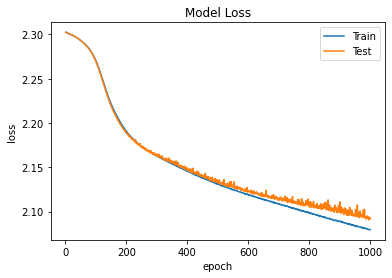

In [ ]:
# Save the plot for loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Test')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
if use_dropout:
    plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout_loss.pdf')
    plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout_loss.png')
else:
    plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout_loss.pdf')
    plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout_loss.png')
#plt.close()

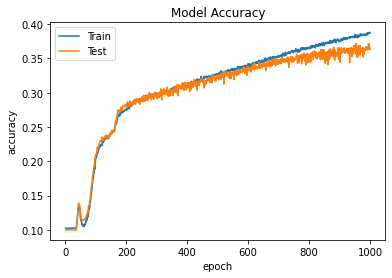

In [ ]:
# Save the plot for accuracies
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
if use_dropout:
    plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout_accuracy.pdf')
    plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_dropout_accuracy.png')
else:
    plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout_accuracy.pdf')
    plt.savefig(f'/content/gdrive/My Drive/Colab Output/results/{num_ch_c1}_{num_ch_c2}_{optimizer_}_no_dropout_accuracy.png')
#plt.close()

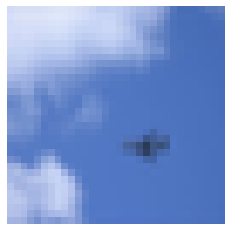

In [ ]:
# Pick a random image to reshape and display
NUM_CHANNELS = 3
IMG_SIZE = 32
loaded_image = x_train[1335].reshape(NUM_CHANNELS, IMG_SIZE, IMG_SIZE)

# Visualize Data
plt.figure()
plt.gray()
plt.axis('off')
plt.imshow(loaded_image.transpose(1,2,0))

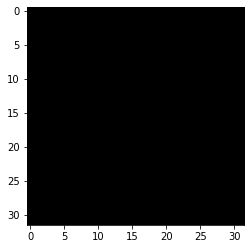

(1, 3, 32, 32)


In [ ]:
from keras.preprocessing import image
img = loaded_image
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0].transpose(1,2,0))
plt.show()

print(img_tensor.shape)

In [ ]:
from tensorflow.keras import models

layer_outputs = [layer.output for layer in model.layers[:12]] 

# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

activations = activation_model.predict(img_tensor) 
# Returns a list of five Numpy arrays: one array per layer activation
first_layer_activation = activations[0]
print(first_layer_activation.shape)

NameError: ignored